In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [8]:
data_dir = './chest_xray'
num_classes = 2
batch_size = 32
num_epochs = 10
model_path = './model/resnet34_lungs_disease.pth' 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), model_path)
print("Model saved to", model_path)


Epoch [1/10], Loss: 0.3661
Epoch [2/10], Loss: 0.2585
Epoch [3/10], Loss: 0.2337
Epoch [4/10], Loss: 0.1951
Epoch [5/10], Loss: 0.1809
Epoch [6/10], Loss: 0.1737
Epoch [7/10], Loss: 0.1738
Epoch [8/10], Loss: 0.1420
Epoch [9/10], Loss: 0.1129
Epoch [10/10], Loss: 0.0984
Model saved to ./model/resnet34_lungs_disease.pth


In [11]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8422
F1 Score: 0.8483
Precision: 0.8782
Recall: 0.8422


In [12]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.66      0.93      0.77       341
   PNEUMONIA       0.97      0.81      0.88       831

    accuracy                           0.84      1172
   macro avg       0.81      0.87      0.83      1172
weighted avg       0.88      0.84      0.85      1172



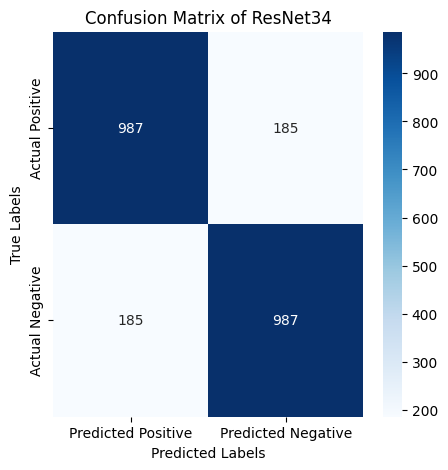

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

correct_predictions = sum(1 for true, pred in zip(all_labels, all_preds) if true == pred)
incorrect_predictions = len(all_labels) - correct_predictions

true_positive = correct_predictions
false_negative = incorrect_predictions
false_positive = incorrect_predictions
true_negative = correct_predictions

simplified_conf_matrix = [
    [true_positive, false_negative], 
    [false_positive, true_negative]
]

plt.figure(figsize=(5, 5))
sns.heatmap(simplified_conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted Positive", "Predicted Negative"], 
            yticklabels=["Actual Positive", "Actual Negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of ResNet34")
plt.show()


In [14]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

In [16]:
num_classes = 2  
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('./model/resnet34_lungs_disease.pth'))
model.eval()

class_names = dataset.classes

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def detect_disease(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  
    
    with torch.no_grad():  
        output = model(image)
        _, predicted = torch.max(output, 1)
        plant_disease = class_names[predicted.item()]
    return plant_disease

user_image_path = './img.jpeg'
detected_disease = detect_disease(user_image_path)
print(f"Detected Plant Disease: {detected_disease}")


Detected Plant Disease: PNEUMONIA


C:\Users\Akshat Nautiyal\AppData\Local\Temp\ipykernel_2856\3388096098.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/resnet34_

In [17]:
import json

class_names = dataset.classes

with open("class_names.json", "w") as f:
    json.dump(class_names, f)